In [ ]:
######### Import Libraries ###########
# basics
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import enum
from tqdm import tqdm

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import autograd

#statistics
import scipy.integrate as integrate 
from scipy.stats import norm
import statsmodels.distributions as smd
from scipy.special import rel_entr
from scipy.spatial import distance
from scipy.stats import wasserstein_distance
from sklearn.metrics import confusion_matrix

# not used
# import matplotlib.animation as anim
# from IPython.display import HTML

device = torch.device('cuda:0' if (torch.cuda.is_available() ) else 'cpu')
print(device)

cuda:0


In [ ]:
#-- Discriminator/Critic

class Critic(nn.Module):
    " A dense net"
    def __init__(self, 
                 c_dim = 2, # conditional dimension
                 input_dim = 1,
                 output_dim = 1,
                 hidden_neurons = [200,200,200,200], 
                 activation = nn.LeakyReLU(0.1)
                 ):
        super(Critic, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + c_dim ,hidden_neurons[0]),
            activation,
            nn.Linear(hidden_neurons[0],hidden_neurons[1]),
            activation,
            nn.Linear(hidden_neurons[1],hidden_neurons[2]),
            activation,
            nn.Linear(hidden_neurons[2],hidden_neurons[3]),
            activation,
            nn.Linear(hidden_neurons[3],output_dim)
        )
   

    def forward(self,x):
        output = self.model(x)
        return output

#-- Generator

class Generator(nn.Module):
    def __init__(self,
                 c_dim = 2, # conditional dimension
                 input_dim = 1,
                 output_dim = 1,
                 hidden_neurons = [200,200,200,200], 
                 activation = nn.LeakyReLU(0.1)
                 ):
        super(Generator, self).__init__()
   
        self.model = nn.Sequential(
            nn.Linear(input_dim + c_dim, hidden_neurons[0]),
            activation,
            nn.Linear(hidden_neurons[0],hidden_neurons[1]),
            activation,
            nn.Linear(hidden_neurons[1],hidden_neurons[2]),
            activation,
            nn.Linear(hidden_neurons[2],hidden_neurons[3]),
            activation,
            nn.Linear(hidden_neurons[3],output_dim)
        )


    def forward(self,x):
        output = self.model(x)
        return output

In [ ]:
class jumpType(enum.Enum):
    fixJ = 1.0
    mertonJ = -1.0

class RealData():
    """
    The dataset: log-price
    """
    def __init__(self, 
                 modelpara,
                 jumptype,
                 jumppara):
        
        self.nsteps = modelpara['nsteps']
        self.ndepths = modelpara['ndepths']
        self.T = modelpara['T']
        self.mu = modelpara['mu']
        self.sigma = modelpara['sigma']
        self.dt = modelpara['T'] /float(modelpara['nsteps'])
        self.xiP = jumppara['xiP']
        print("Jump intensity: ", self.dt * self.xiP )
        if self.dt * self.xiP > 1:
            raise TypeError("Wrong jump setting parameters: jump intensity should not be larger than 1!")
        self.jumptype = jumptype
        self.jumppara = jumppara

        
    def generate_GBM(self, S0=100, npaths = 1000):
        """
        Generate the main GBM path
        """
        X0 = np.log(S0)
        GBM_X = np.zeros([npaths,self.nsteps+1])
        Z = np.random.normal(0.0, 1.0, [npaths,self.nsteps])
        GBM_X[:,0] = X0
        for i in range(self.nsteps):
            #Make sure that samples from a normal have mean 0 and variance 1
            if npaths > 1:
                    Z[:,i] = (Z[:,i]-np.mean(Z[:,i]))/np.std(Z[:,i])  
            GBM_X[:,i+1] = GBM_X[:,i] + self.mu* self.dt\
                             + self.sigma * np.sqrt(self.dt) * Z[:,i]
        return GBM_X
    def generate_Monte_GBM(self, GBM_X):
        """
        Generate the 3D dataset
        """
        X0 = GBM_X[0,0]
        npaths= GBM_X.shape[0]
        Monte_GBM_X = np.zeros([npaths,self.nsteps+1,self.ndepths])
        Monte_Z = np.random.normal(loc=0.0, scale=1.0, 
                                   size=[npaths,self.nsteps,self.ndepths-1])
        Monte_GBM_X[:,0,:] = X0
        Monte_GBM_X[:,:,0] = GBM_X
        for i in range(self.nsteps):
            for j in range(npaths):
                # if self.ndepths > 1:
                    # Monte_Z[j,i,:] = (Monte_Z[j,i,:] - np.mean(Monte_Z[j,i,:]))\
                    #                 / np.std(Monte_Z[j,i,:])
                Monte_GBM_X[j,i+1,1:] = GBM_X[j,i] + self.mu * self.dt \
                                    + self.sigma * np.sqrt(self.dt) * Monte_Z[j,i,:]
        return Monte_GBM_X
    
    def generate_fixJ_path(self, GBM_X):
        if self.jumptype.value == -1.0: # The parameters are follow Merton's jump
            raise TypeError("Wrong jump type!")
        else:
            print('Jump type:', self.jumptype)
            X0 = GBM_X[0,0]
            npaths= GBM_X.shape[0]
            p = self.jumppara['p']
            Jsize = self.jumppara['J']
            jump_X = np.zeros([npaths,self.nsteps+1])
            Bernoulli = np.random.binomial(n=1, p=self.xiP * self.dt, 
                                           size=[npaths,self.nsteps])  
            jump_X[:,0] = X0 
            U = np.random.uniform(low=0,high=1,
                                  size=[npaths,self.nsteps])
            J = np.zeros([npaths,self.nsteps])
            for i in range(npaths):
                for j in range(self.nsteps):
                    if U[i,j] <= p:
                        J[i,j] = Jsize
                    else:
                        J[i,j] = -Jsize
            jumpPart = J * Bernoulli
            cum_jump = np.cumsum(jumpPart, axis = 1)
            for i in range(self.nsteps): 
                jump_X[:,i+1] =  GBM_X[:,i+1] + cum_jump[:,i]
        
        return jump_X, Bernoulli, J

    def generate_mertonJ_path(self, GBM_X):
        if self.jumptype.value == 1.0:
            
            raise TypeError("Wrong jump type!")
        else:
            print('Jump type:', self.jumptype)
            X0 = GBM_X[0,0]
            npaths= GBM_X.shape[0]
            muJ = self.jumppara['muJ']
            sigmaJ = self.jumppara['sigmaJ']
            jump_X = np.zeros([npaths,self.nsteps+1])
            Bernoulli = np.random.binomial(n=1, p=self.xiP * self.dt, 
                                           size=[npaths,self.nsteps])  
            jump_X[:,0] = X0 
            J = np.random.normal(loc = muJ, scale = sigmaJ, 
                                 size = [npaths,self.nsteps])
            jumpPart = J * Bernoulli
            cum_jump = np.cumsum(jumpPart, axis = 1)
            for i in range(self.nsteps): 
                jump_X[:,i+1] = GBM_X[:,i+1] +  cum_jump[:,i]
        
        return jump_X, Bernoulli, J

    def build_trainloader(self, batch_size = 100, S0 = 100, npaths = 2000):
        initialS0 = [int(S0/100),
                     int(S0/10),
                     S0,
                     int(S0*10),
                     int(S0*100)]
        nparts = len(initialS0)
        Monte_GBMXs = np.zeros([int(npaths*nparts), 
                                self.nsteps+1, 
                                self.ndepths])
        for l in range(nparts):
            GBM_X = self.generate_GBM(S0,npaths)
            Monte_GBM_X = self.generate_Monte_GBM(GBM_X)
           
            Monte_GBMXs[npaths*l: npaths*(l+1),:] = Monte_GBM_X
        Monte_GBMXs = torch.tensor(Monte_GBMXs,
                                   dtype=torch.float32) 
        train_loader = DataLoader(Monte_GBMXs,
                                  batch_size=batch_size,
                                  shuffle=True)
        return train_loader



In [ ]:
class TrainDistribution():
    def __init__(
        self,
        generator,
        critic, 
        generator_optimizer,
        critic_optimizer,
        trainloader,
        lr_step,
        lr_gamma,
        min_lr,
        critic_iter,
        gp_lambda,
        latent_dim,
        model_para,
        device
        ):
        
        self.generator = generator
        self.critic = critic
        self.generator_optimizer = generator_optimizer
        self.critic_optimizer = critic_optimizer

        self.device = device

        self.trainloader = trainloader
        self.latent_dim = latent_dim
        self.model_para = model_para
        self.critic_iter = critic_iter
        self.gp_lambda = gp_lambda
        self.min_lr = min_lr

        self.critic_scheduler = torch.optim.lr_scheduler.StepLR(
            self.critic_optimizer, 
            step_size = lr_step, 
            gamma = lr_gamma
            )
        self.generator_scheduler = torch.optim.lr_scheduler.StepLR(
            self.generator_optimizer, 
            step_size = lr_step, 
            gamma = lr_gamma
            )
  
    def prepare_data(self, MonteXt): 
        """
        Input: 
            MonteXt: [npaths,nsteps,ndepth], the log-GBM training dataset using nested Monte Carlo
        Output:
            dt: [npaths,ndepth], the condition regarding the timestep 
            Monte_X0: [npaths, ndepth], the condition regarding the current state
            real_Monte_Xt: [npaths,ndepth], the real future state
        """
        MonteXt = MonteXt.to(self.device)
        indices = np.random.randint(self.model_para['nsteps'])
        delta_t = self.model_para['T']/float(self.model_para['nsteps'])
        dt = torch.tensor(
            np.ones([MonteXt.size(0),MonteXt.size(2)])*delta_t, 
            dtype=torch.float32,
            device=self.device
            )
        Monte_X0 = MonteXt[:,indices,:].to(self.device)
        real_Monte_Xt = MonteXt[:,indices+1,:].to(self.device)

        return dt, Monte_X0, real_Monte_Xt
    
    def calculate_gradient_penalty(self, real_samples, fake_samples):

        length = real_samples.size(0)
        depth = real_samples.size(1)

        eta = torch.FloatTensor(length,1).uniform_(0,1)
        eta = eta.expand(length, depth)
        eta = eta.to(self.device)

        interpolated = (eta * real_samples \
                        + ((1 - eta) * fake_samples)).to(self.device)

        interpolated = Variable(interpolated, requires_grad=True)

        # calculate probability of interpolated examples
        prob_interpolated = self.critic(interpolated)

        # calculate gradients of probabilities with respect to examples
        gradients = autograd.grad(outputs = prob_interpolated, 
                                inputs = interpolated,
                                grad_outputs = torch.ones(
                                    prob_interpolated.size()).to(self.device),
                                create_graph = True, 
                                retain_graph = True)[0]

        grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() \
                        * self.gp_lambda

        return grad_penalty
  
    def train_critic_step(self, dt, Monte_X0, real_Monte_Xt):

        length = real_Monte_Xt.size(0)
        depth = self.latent_dim

        # initialize latent variable
        z = np.random.normal(0.0, 1.0,[length,depth])
        z = torch.tensor(z,dtype=torch.float32)
        z = z.to(self.device) 
        
        # Conditioned real samples
     
        conditional_real_samples = torch.cat(                                   
                                        (real_Monte_Xt, dt, Monte_X0), 
                                        dim = -1
                                        )
        
        # The conditioned input of the generator
        conditional_fake_latent_samples = torch.cat(                            
                                        (z, dt, Monte_X0),
                                        dim = -1
                                        )
        # The output of the generator
        G_z = self.generator(conditional_fake_latent_samples)                   
        # Conditioned generated samples
        conditional_fake_samples = torch.cat(                                   
                                        (G_z,dt,Monte_X0),
                                        dim = -1)
        
        self.critic.zero_grad() 

        # Add gradient penalty
        gradient_penalty = self.calculate_gradient_penalty(
                                    conditional_real_samples,
                                    conditional_fake_samples,
                                    )
        gradient_penalty.backward(retain_graph=True)

        # Calculate the critic loss
        loss_D = \
        self.critic(conditional_fake_samples).mean() \
        - self.critic(conditional_real_samples).mean() \
        + gradient_penalty

        loss_D.backward(retain_graph=True)

        self.critic_optimizer.step()
        self.critic.zero_grad()

        return loss_D.item()
  
    def train_generator_step(self, dt, Monte_X0, real_Monte_Xt):

        length = real_Monte_Xt.size(0)
        depth = self.latent_dim

        # Initial latent variable
        z = np.random.normal(0.0, 1.0,[length,depth])
        z = torch.tensor(z,dtype=torch.float32)
        z = z.to(self.device)

        # The conditioned input of the generator
        conditional_fake_latent_samples = torch.cat(
                                                (z, dt, Monte_X0),
                                                dim = -1) 
        # The output of the generator
        for p in self.critic.parameters():
            p.requires_grad = False

        self.generator.zero_grad()

        G_z = self.generator(conditional_fake_latent_samples)

        # save the output of the generator: G(z,dt,Xt)
        generated_pattern = G_z.cpu().detach().numpy()
    
        # The conditioned generated samples
        conditional_fake_samples = torch.cat(
                                        (G_z, dt, Monte_X0),
                                        dim = -1)
        
        # Calculate the generator loss
        loss_G = - self.critic(conditional_fake_samples).mean()
        loss_G.backward()

        self.generator_optimizer.step()
        self.generator.zero_grad()

        return generated_pattern, loss_G.item() 

    def trainingloop(self, nepochs):
        D_losses = []
        G_losses = []
        Generated_results = []

        for epoch in range(nepochs):
            D_loss_acc = 0
            G_loss_acc = 0

            self.critic.train()
            self.generator.train()

            progress_bar = tqdm(self.trainloader, unit="batch")
            for i, MonteXt in enumerate(progress_bar):

                dt, Monte_X0, real_Monte_Xt = self.prepare_data(MonteXt)
      
                for p in critic.parameters():
                    p.requires_grad = True

                # Training the critic
                for iter in range(self.critic_iter): 
                    critic_loss = self.train_critic_step(dt, 
                                                         Monte_X0, 
                                                         real_Monte_Xt)
                    D_loss_acc += critic_loss

                # Training the generator
                generated_pattern, \
                generator_loss = self.train_generator_step(dt, 
                                                           Monte_X0, 
                                                           real_Monte_Xt)
                G_loss_acc += generator_loss
                
                progress_bar.set_description(f"Epoch {epoch+1}")
                progress_bar.set_postfix(avg_D_loss=D_loss_acc / 
                                         (i * self.critic_iter+1),                                              
                                         avg_G_loss=G_loss_acc / (i+1))

                D_losses.append(critic_loss)
                G_losses.append(generator_loss) 
                Generated_results.append(generated_pattern)

            if self.generator_scheduler.get_last_lr()[0] > self.min_lr:
                self.generator_scheduler.step()

            if self.critic_scheduler.get_last_lr()[0] > self.min_lr:
                self.critic_scheduler.step()

        return D_losses, G_losses, Generated_results
   

In [ ]:
class FitDistribution():
    def __init__(
        self,
        generator,
        critic, 
        fitmodelpara,
        device
        ):
        self.generator = generator
        self.critic = critic
        self.npaths = fitmodelpara['npaths']
        self.nsteps = fitmodelpara['nsteps']
        self.ndepths = fitmodelpara['ndepths']
        self.T = fitmodelpara['T']
        self.S0 = fitmodelpara['S0']
        self.mu = fitmodelpara['mu']
        self.sigma = fitmodelpara['sigma']
        self.dt = fitmodelpara['T'] /float(fitmodelpara['nsteps'])
    
    def fit(self,test_Monte_GBM):
        length = self.npaths
        depth = self.ndepths
        width = self.nsteps

        generate_GAN_Monte = np.zeros([length,width+1,depth])
        generate_GAN_Monte[:,0,:] = np.log(self.S0)
        dt = torch.tensor(np.ones([length,depth]) * self.dt, 
                                dtype=torch.float32)
        dt = dt.to(device)

        for i in range(width):
            z = np.random.normal(0.0, 1.0,[length,depth])
            z = torch.tensor(z,dtype=torch.float32)
            z = z.to(device)

            X0 = test_Monte_GBM[:,i,:]
            x0 = torch.tensor(X0,dtype=torch.float32)
            x0 = x0.to(device)

            conditional_fake_latent_samples = torch.cat((z,dt,x0),
                                                        dim = -1)
            G_z = self.generator(conditional_fake_latent_samples)
            generate_GAN_Monte[:,i+1,:] = G_z.cpu().detach().numpy()
        return generate_GAN_Monte

    def GBM_fit(self,test_GBM):
        length = self.npaths
        depth = self.ndepths
        width = self.nsteps

        generate_GAN_Monte = np.zeros([length,width+1,depth])
        generate_GAN_Monte[:,0,:] = np.log(self.S0)
        dt = torch.torch.tensor(np.ones([length,depth]) * self.dt, 
                                dtype=torch.float32)
        dt = dt.to(device)

        for i in range(width):
            z = np.random.normal(0.0, 1.0,[length,depth])
            z = torch.tensor(z,dtype=torch.float32)
            z = z.to(device)

            X0 = np.resize(test_GBM[:,i] , [length,depth])
            x0 = torch.tensor(X0,dtype=torch.float32)
            x0 = x0.to(device)

            conditional_fake_latent_samples = torch.cat((z,dt,x0),
                                                        dim = -1)
            G_z = self.generator(conditional_fake_latent_samples)
            generate_GAN_Monte[:,i+1,:] = G_z.cpu().detach().numpy()
        return generate_GAN_Monte

In [ ]:
class PathGenerate():
    def __init__(
        self,
        generator,
        critic, 
        fitmodelpara,
        device
        ):
        self.generator = generator
        self.critic = critic
        self.npaths = fitmodelpara['npaths']
        self.nsteps = fitmodelpara['nsteps']
        self.ndepths = fitmodelpara['ndepths']
        self.T = fitmodelpara['T']
        self.S0 = fitmodelpara['S0']
        self.mu = fitmodelpara['mu']
        self.sigma = fitmodelpara['sigma']
        self.dt = fitmodelpara['T'] /float(fitmodelpara['nsteps'])
    def PathSimulation(self):
        length = self.npaths
        depth = self.ndepths
        width = self.nsteps

        paths = np.zeros([length,width+1,depth])
        paths[:,0,:] = np.log(self.S0)
        
        dt = torch.torch.tensor(np.ones([length,depth]) * self.dt, 
                                dtype=torch.float32)
        dt = dt.to(device)

        for i in range(width):
            z = np.random.normal(0.0, 1.0,[length,depth])
            z = torch.tensor(z,dtype=torch.float32)
            z = z.to(device)

            X0 = np.resize(paths[:,i,:],[length,depth])
            x0 = torch.tensor(X0,dtype=torch.float32)
            x0 = x0.to(device)

            conditional_fake_latent_samples = torch.cat((z,dt,x0),
                                                        dim = -1)
            G_z = self.generator(conditional_fake_latent_samples)
            paths[:,i+1,:] = G_z.cpu().detach().numpy()
        
        return paths


In [ ]:
def set_jumppara(jumptype, xiP, J, p, muJ, sigmaJ):
    if jumptype == jumpType.fixJ:
        jumppara = dict(xiP=xiP, J=J, p=p)
        return jumppara
    if jumptype == jumpType.mertonJ:
        jumppara = dict(xiP=xiP, muJ=muJ, sigmaJ=sigmaJ)
        return jumppara

jump_elements = {
    'xiP': 1,
    'J': 1,
    'p': 0.5,
    'muJ': 0.15,
    'sigmaJ': 0.11
}

modelPara = {
    'npaths': 10000,
    'nsteps': 500,
    'ndepths': 10,
    'T': 500*0.000002,
    'S0': 100,
    'mu': 0.2,
    'sigma': 0.15 
}
testPara = {
    'npaths': 1000,
    'nsteps': 500,
    'ndepths': 10,
    'T': 500*0.000002,
    'S0': 100,
    'mu': 0.2,
    'sigma': 0.15 
}

distributionPara = {
    'npaths': 10000,
    'nsteps': 1,
    'ndepths': 10,
    'T': 0.02,
    'S0': 3000,
    'mu': 0.05,
    'sigma': 0.2 
}


generator_params = {
  "c_dim": 2 * modelPara['ndepths'],
  "input_dim": modelPara['ndepths'],
  "output_dim": modelPara['ndepths'], 
  "hidden_neurons": [100,100,100,100],
  "activation":nn.LeakyReLU(0.1)
}
critic_params = {
  "c_dim": 2 * modelPara['ndepths'], 
  "input_dim": modelPara['ndepths'],
  "output_dim": 1,
  "hidden_neurons":  [100,100,100,100],
  "activation":nn.LeakyReLU(0.1)
}


dataset_parameters = {
    'modelpara': modelPara,
    'jumptype': jumpType.mertonJ,
    'jumppara': set_jumppara(jumpType.mertonJ, **jump_elements)
}

jumpdistribution_parameters = {
    'modelpara': distributionPara,
    'jumptype': jumpType.mertonJ,
    'jumppara': set_jumppara(jumpType.mertonJ, **jump_elements)
}

jumppaths_parameters = {
    'modelpara': modelPara,
    'jumptype': jumpType.mertonJ,
    'jumppara': set_jumppara(jumpType.mertonJ, **jump_elements)
}


training_parameters = {
  'lr_step': 20,
  'lr_gamma': 0.3,
  'min_lr': 1e-08,
  'critic_iter': 9,
  'gp_lambda': 60,
  'latent_dim': modelPara['ndepths'],
  'model_para': modelPara,
  'device': device
}


In [ ]:

dt_list = [0.00001,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.2,0.5,0.8]
weakerror = []
strongerror = []

for dt in range(len(dt_list)):
    modelPara['T'] = 500 * float(dt_list[dt])
    testPara['T'] = 500 * float(dt_list[dt])
    realdata = RealData(**dataset_parameters)
    print(dataset_parameters['modelpara'])
    trainloader = realdata.build_trainloader(batch_size=100,
                                        S0 = modelPara['S0'], 
                                        npaths=2000)
    
    generator = Generator(**generator_params).to(device)
    critic = Critic(**critic_params).to(device)

    lr = 0.0003
    generator_optimizer = optim.RMSprop(generator.parameters(), lr = lr)
    critic_optimizer = optim.RMSprop(critic.parameters(), lr = lr)

    trainer = TrainDistribution(
        generator=generator,
        critic=critic, 
        generator_optimizer=generator_optimizer,
        critic_optimizer=critic_optimizer,
        trainloader = trainloader,
        **training_parameters
        )

    D_losses, G_losses, Generated_results = trainer.trainingloop(nepochs=100)
    test_GBM = realdata.generate_GBM(S0=100, npaths = 1000)
    test_Monte_GBM = realdata.generate_Monte_GBM(test_GBM)
    
    pathsimulate = PathGenerate(
        generator,
        critic, 
        testPara,
        device)
    GAN_paths = pathsimulate.PathSimulation() 

    test_XT = test_Monte_GBM[:,-1,:]
    fake_XT = GAN_paths[:,-1,:]
    strongerror.append(np.mean(np.abs(fake_XT - test_XT)))
    weakerror.append(np.abs(np.mean(fake_XT) - np.mean(test_XT)))

    fitfunc = FitDistribution(
    generator,
    critic, 
    testPara,
    device)
    GAN_Monte = fitfunc.fit(test_Monte_GBM)

    Q = np.reshape(test_Monte_GBM,-1)
    P = np.reshape(GAN_Monte,-1)
    
    print('W:',wasserstein_distance(P,Q))
 


Jump intensity:  1e-05
{'npaths': 10000, 'nsteps': 500, 'ndepths': 10, 'T': 0.005, 'S0': 100, 'mu': 0.2, 'sigma': 0.15}


Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 15.17batch/s, avg_D_loss=-.00361, avg_G_loss=2.01]


W: 0.002189384514077104
Jump intensity:  0.0001
{'npaths': 10000, 'nsteps': 500, 'ndepths': 10, 'T': 0.05, 'S0': 100, 'mu': 0.2, 'sigma': 0.15}


Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 15.16batch/s, avg_D_loss=-.0025, avg_G_loss=3.16]


W: 0.0009285765959612225
Jump intensity:  0.0005
{'npaths': 10000, 'nsteps': 500, 'ndepths': 10, 'T': 0.25, 'S0': 100, 'mu': 0.2, 'sigma': 0.15}


Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 14.91batch/s, avg_D_loss=-.00069, avg_G_loss=1.32]


W: 0.002208027305299294
Jump intensity:  0.001
{'npaths': 10000, 'nsteps': 500, 'ndepths': 10, 'T': 0.5, 'S0': 100, 'mu': 0.2, 'sigma': 0.15}


Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 14.65batch/s, avg_D_loss=-.000279, avg_G_loss=-.798]


W: 0.0033773166426254533
Jump intensity:  0.005
{'npaths': 10000, 'nsteps': 500, 'ndepths': 10, 'T': 2.5, 'S0': 100, 'mu': 0.2, 'sigma': 0.15}


Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 14.86batch/s, avg_D_loss=4.48e-5, avg_G_loss=3.33]


W: 0.009697193898395582
Jump intensity:  0.01
{'npaths': 10000, 'nsteps': 500, 'ndepths': 10, 'T': 5.0, 'S0': 100, 'mu': 0.2, 'sigma': 0.15}


Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 14.71batch/s, avg_D_loss=-.00154, avg_G_loss=-9.36]


W: 0.012310747140165536
Jump intensity:  0.05
{'npaths': 10000, 'nsteps': 500, 'ndepths': 10, 'T': 25.0, 'S0': 100, 'mu': 0.2, 'sigma': 0.15}


Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 14.93batch/s, avg_D_loss=-.00114, avg_G_loss=-17]


W: 0.004780466702646937
Jump intensity:  0.1
{'npaths': 10000, 'nsteps': 500, 'ndepths': 10, 'T': 50.0, 'S0': 100, 'mu': 0.2, 'sigma': 0.15}


Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 14.77batch/s, avg_D_loss=-.000298, avg_G_loss=0.0421]


W: 0.0077906296479807475
Jump intensity:  0.2
{'npaths': 10000, 'nsteps': 500, 'ndepths': 10, 'T': 100.0, 'S0': 100, 'mu': 0.2, 'sigma': 0.15}


Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 14.70batch/s, avg_D_loss=-.00539, avg_G_loss=-28.9]


W: 0.0033185242268611104
Jump intensity:  0.5
{'npaths': 10000, 'nsteps': 500, 'ndepths': 10, 'T': 250.0, 'S0': 100, 'mu': 0.2, 'sigma': 0.15}


Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 14.78batch/s, avg_D_loss=-.0251, avg_G_loss=49.4]


W: 0.025276896547215027
Jump intensity:  0.8
{'npaths': 10000, 'nsteps': 500, 'ndepths': 10, 'T': 400.0, 'S0': 100, 'mu': 0.2, 'sigma': 0.15}


Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 14.44batch/s, avg_D_loss=-.00856, avg_G_loss=101]


W: 0.21127443049045627


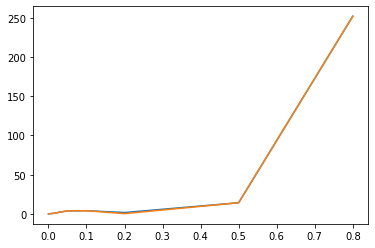

In [ ]:
plt.plot(dt_list,strongerror)
plt.plot(dt_list,weakerror)

In [ ]:


realdata = RealData(**dataset_parameters)
print(dataset_parameters['modelpara'])
trainloader = realdata.build_trainloader(batch_size=100,
                                    S0 = modelPara['S0'], 
                                    npaths=2000)
generator = Generator(**generator_params).to(device)
critic = Critic(**critic_params).to(device)

lr = 0.0003
generator_optimizer = optim.RMSprop(generator.parameters(), lr = lr)
critic_optimizer = optim.RMSprop(critic.parameters(), lr = lr)

trainer = TrainDistribution(
  generator=generator,
  critic=critic, 
  generator_optimizer=generator_optimizer,
  critic_optimizer=critic_optimizer,
  trainloader = trainloader,
  **training_parameters
)

D_losses, G_losses, Generated_results = trainer.trainingloop(nepochs=100)

Jump intensity:  1e-05
{'npaths': 10000, 'nsteps': 500, 'ndepths': 10, 'T': 0.005, 'S0': 100, 'mu': 0.2, 'sigma': 0.15}


Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 15.16batch/s, avg_D_loss=-.00401, avg_G_loss=3.64]


In [ ]:
pathsimulate = PathGenerate(
        generator,
        critic, 
        testPara,
        device)
generated_paths = pathsimulate.PathSimulation()

In [ ]:
generated_paths

In [ ]:
test_GBM = realdata.generate_GBM(S0=100, npaths = 1000)
test_Monte_GBM = realdata.generate_Monte_GBM(test_GBM)

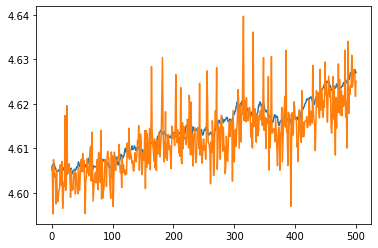

In [ ]:
plt.plot(np.transpose(test_GBM[:1]))
plt.plot(np.transpose(GAN_Monte[:1,:,0]))

In [ ]:
fitfunc = FitDistribution(
        generator,
        critic, 
        testPara,
        device)
GAN_Monte = fitfunc.fit(test_Monte_GBM)

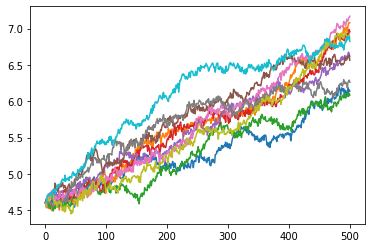

In [ ]:
plt.plot(np.transpose(GAN_Monte[:10,:,0]))

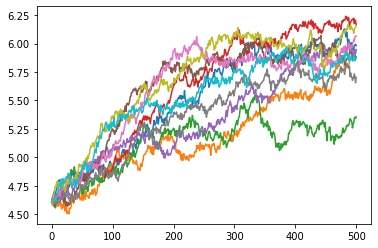

In [ ]:
plt.plot(np.transpose(generated_paths[:10,:,0]))
plt.show()

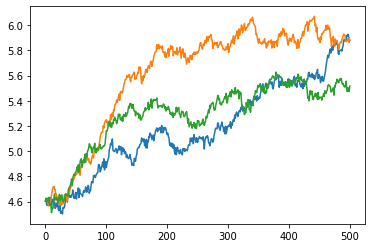

In [ ]:
p = 1500
plt.plot(generated_paths[1,:,0])
plt.plot(generated_paths[5,:,0])
plt.plot(generated_paths[500,:,5])

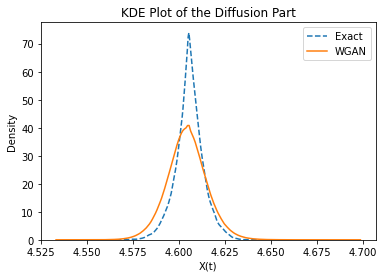

In [ ]:
sns.kdeplot(np.reshape(test_Monte_GBM,-1), linestyle='--',label = 'Exact')
sns.kdeplot(np.reshape(GAN_Monte,-1), linestyle='-',label = 'WGAN')
plt.xlabel('X(t)')
plt.legend()
plt.title('KDE Plot of the Diffusion Part')
plt.show()